In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
output_saved_model_dir="facenet trt model"
# load the model
model = tf.saved_model.load(output_saved_model_dir)

In [3]:
from tensorflow.python.compiler.tensorrt import test

In [4]:
def create_pairs(x, digit_indices, distinct_labels_length):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(distinct_labels_length)]) - 1
    
    for d in range(distinct_labels_length):
        if len(digit_indices[d]) > 1:
            for i in range(len(digit_indices[d]) - 1):
                z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, distinct_labels_length)
                dn = (d + inc) % distinct_labels_length
                random_index =  random.randrange(1, len(digit_indices[dn]))
                z1, z2 = digit_indices[d][i], digit_indices[dn][random_index]
                pairs += [[x[z1], x[z2]]]
                labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels, distinct_labels_length):
    
    digit_indices = [np.where(labels == i)[0] for i in range(distinct_labels_length)]
    pairs, y = create_pairs(images, digit_indices, distinct_labels_length)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image, mean, std):
    plt.figure()
    plt.imshow(((image * std) + mean).astype("uint8"))
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
import numpy as np
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (0,) (0,)


In [6]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
out_encoder = LabelEncoder()
out_encoder.fit(testy)
testy = out_encoder.transform(testy)

In [7]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [8]:
images, labels=(trainX, trainy)

In [9]:
images = np.array([image for image in images])
mean, std = images.mean(), images.std()
images = (images - mean)/std 
print(images.shape)
tr_pairs, tr_y = create_pairs_on_set(images, labels, 5)

(93, 160, 160, 3)


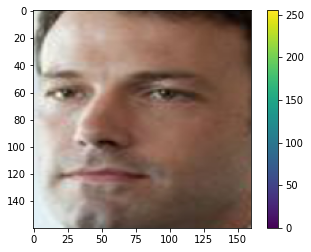

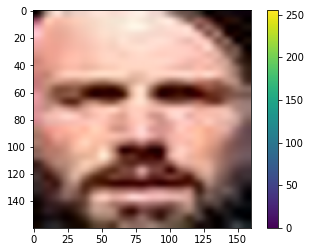

1.0


In [10]:
# array index
this_pair = 8

# show images at this index
show_image(tr_pairs[this_pair][0], mean, std)
show_image(tr_pairs[this_pair][1], mean, std)

# print the label for this pair
print(tr_y[this_pair])

In [11]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = tf.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model(samples)
	return yhat[0]

In [12]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(sum_square)

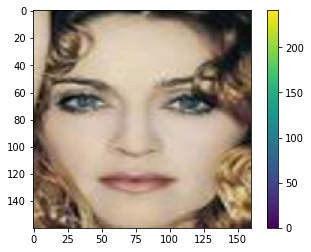

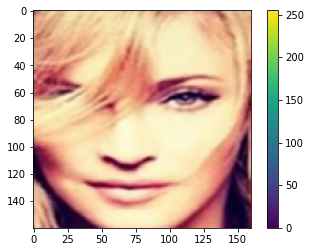

1.0
tf.Tensor([[11.622798]], shape=(1, 1), dtype=float32)


In [16]:
# array index
this_pair = 116

# show images at this index
show_image(tr_pairs[this_pair][0], mean, std)
show_image(tr_pairs[this_pair][1], mean, std)

# print the label for this pair
print(tr_y[this_pair])
x = get_embedding(model, tr_pairs[this_pair][0]).numpy()

y = get_embedding(model, tr_pairs[this_pair][1]).numpy()

print(euclidean_distance([x.reshape(1, 128), y.reshape(1, 128)]))

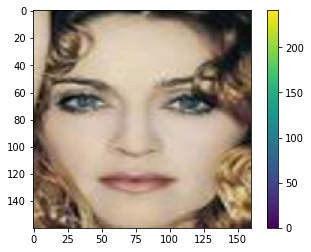

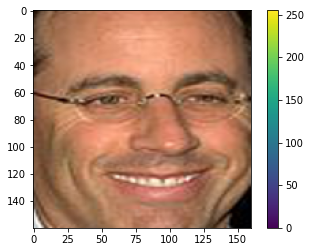

0.0
tf.Tensor([[16.541348]], shape=(1, 1), dtype=float32)


In [17]:
# array index
this_pair = 117

# show images at this index
show_image(tr_pairs[this_pair][0], mean, std)
show_image(tr_pairs[this_pair][1], mean, std)

# print the label for this pair
print(tr_y[this_pair])
x = get_embedding(model, tr_pairs[this_pair][0]).numpy()

y = get_embedding(model, tr_pairs[this_pair][1]).numpy()

print(euclidean_distance([x.reshape(1, 128), y.reshape(1, 128)]))

In [15]:
#model.save("facenet saved model")